# Machine Learning Engineer Capstone Project
## Starbucks Challenge
### by Mark-Danney Oonk

---

This notebook describes:
- The project definition with an overview of the project, the problem statement and metrics to be used;
- Data analysis and preprocessing

The code in this notebook results in:
- data/baselineData.csv with preprocessed baseline data to be used in training a baseline model;
- data/history.csv with preprocessed data to be used in training the actual model;
- model/scaler.save with the fitted scaler so it can be used when processing individual recommendatations;
- ./model/SCALED_COLS with the ordered names of scaled columns so scaling information may be retrieved.

## Definition

### Project Overview

Starbucks wants to target users of their app with personalized messages, giving its customers the best possible offers on the right channels in order to stimulate their spending behavior.

To this end, Starbucks ran a pilot with several different propositions and monitoring whether, and if so when, the offer was viewed. Any consequent spending behavior of the pilot customers was logged. Using this data we will train a machine learning model that can be exposed in an endpoint in order to provide the app, e-mail or online channels with the best offers for a given customer in real-time.

Starbucks has provided us with three related datasets:
- Profiles, containing information about customers such as age, gender, account age and income;
- a Portfolio of available offers describing their difficulty to attain the offer (required spending before a Buy one, Get one free (BOGO) kicks in for instance), offer duration and the amount rewarded;
- Transcripts of monetary transactions as well as the dates offers were sent, viewed and completed by customers.

### Problem Statement

The problem is very similar to a so-called collaborative filtering personalization, where customers are recommended products based on their earlier interests similar to other customers that then recommended other products. Only in this case, the recommended products are new offers and recommendations made by others are them actually spending in order to complete the order.

Collaborative filtering personalization has in the past been successfully implemented using neural networks, so this will be the route taken for the problem at hand. The output of the model will be an ordered list of offer/channel combinations, along with and ordered by the predicted customer spending.

### Metrics

Model success will be measured by a combination of Log Loss, as this metric works well at measuring multi-class classification quality by penalizing erroneous classification based on uncertainty of the predictions, and F-1 score to measure the precision and recall. [[3]](#3)

Log loss:

![formula](https://latex.codecogs.com/svg.image?%5Cfrac%7B-1%7D%7BN%7D%5Csum_%7Bi=1%7D%5E%7BN%7D%5Csum_%7Bj=1%7D%5E%7BM%7Dy_%7Bij%7D%5Ctimes%20%5Clog(p_%7Bij%7D))

where:
- y_ij indicates whether sample i belongs to class j or not
- p_ij indicates the probability of sample i belonging to class j

In the context of the problem at hand, it pushes the model towards the right money spent prediction per offer/channel.

F-1:

![formula](https://latex.codecogs.com/svg.image?%5Cfrac%7Btp%7D%7Btp%20+%20%5Cfrac%7B1%7D%7B2%7D(fp%20+%20fn)%7D)

where:
- tp, fp are the number of true resp. false positives
- tn, fn are the number of true resp. false negatives

Positives and negatives will be measured by the outcome of the neuron, >=0.5 is positive, <0.5 is negative.

## Analysis

### Data Exploration

In [53]:
# imports

import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as psql
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, MinMaxScaler
from scipy import stats
from typing import Tuple

In [54]:
# read in the data files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [55]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [56]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

<AxesSubplot:>

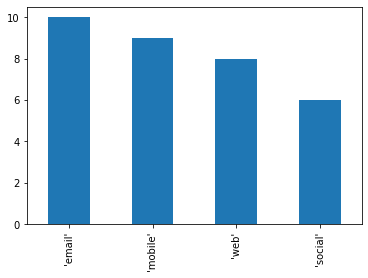

In [57]:
portfolio.channels.apply(str).replace(['\[', '\]'], '', regex=True).str.split(', ', expand=True).stack().value_counts().plot(kind='bar')

The portfolio dataset contains offers sent during 30-day test period (10 offers x 6 fields):

- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

It contains only properly filled records. Required preprocessing will be:

- One-hot encoding of Channels and OfferType
- Min-Max normalization of Reward, Difficulty and Duration to 0..1 values

In [58]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


mean: 54.39352445193929, stdev: 17.383119058990765


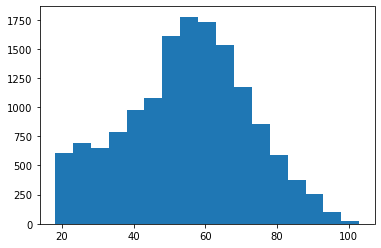

In [59]:
binwidth = 5
data = profile[profile.age != 118].age
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
print('mean: {}, stdev: {}'.format(np.mean(data), np.std(data)))

The participant age is fairly normally-distributed, with a skew to the 18-35 bracket as may be expected for app usage.

female/male distribution: 0.72


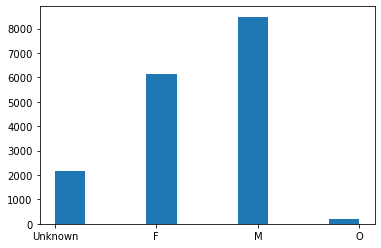

In [60]:
plt.hist(profile.gender.fillna("Unknown"))
print('female/male distribution: {0:.2f}'.format(profile[profile.gender == 'F'].gender.count() / profile[profile.gender == 'M'].gender.count()))

In [61]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [62]:
profileNulls = profile.loc[(profile.gender.isnull()) & (profile.income.isnull()) & (profile.age == 118)]
profileCleaned = profile.loc[(profile.gender.notnull()) & (profile.income.notnull()) & (profile.age != 118)]

print('Percentage of invalid profiles: %.2f' % (profileNulls.shape[0] / profile.shape[0] * 100))
print('Remaining profiles: %d' % profileCleaned.shape[0])

Percentage of invalid profiles: 12.79
Remaining profiles: 14825


Profiles contain the rewards program users (17000 users x 5 fields)

- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

Almost 13% of the profiles aren't filled in correctly. Interestingly though, all of the profiles that contained missing values were missing all three Gender, Age and Income. This may indicate that the data isn't simply missing but may actually be purposefully not filled in by the user. This group will be analyzed as its own demographic to see if we can identify recurring spending behavior.

Required preprocessing will be:

- One-hot encoding of Gender
- Translating BecameMemberOn to AccountAge in days
- Filling missing Age and Income fields with mean values for that column
- Min-Max normalization of Age, Income and AccountAge to 0..1 values

In [63]:
print(transcript.shape[0])
transcript.head()

306534


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Since the Value column contains JSON information, we'll unpack that into separate columns.

In [64]:
df1 = pd.DataFrame(transcript['value'].values.tolist())
df1.columns = df1.columns
df1.offer_id.fillna(df1['offer id'], inplace=True) # Some events call it offer_id, some offer id. So, merge those together
del df1['offer id']

transcriptExpanded = pd.concat([transcript, df1], axis=1)
transcriptExpanded = transcriptExpanded.drop(columns='value')

transcriptExpanded.amount = pd.to_numeric(transcriptExpanded.amount, downcast='float')
transcriptExpanded.reward = pd.to_numeric(transcriptExpanded.reward, downcast='float')
transcriptExpanded.time = pd.to_numeric(transcriptExpanded.time, downcast='integer')
transcriptExpanded = transcriptExpanded.astype({'offer_id':str, 'person': str, 'event': str})

print(transcriptExpanded.dtypes)
transcriptExpanded.head()

person       object
event        object
time          int16
amount      float32
offer_id     object
reward      float32
dtype: object


,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [65]:
transcriptExpanded.isnull().sum()

person           0
event            0
time             0
amount      167581
offer_id         0
reward      272955
dtype: int64

In [66]:
transcriptExpanded.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [67]:
transcriptEmptyProfiles = transcriptExpanded.loc[transcriptExpanded.person.isin(profileNulls.id)]
transcriptCleaned = transcriptExpanded.loc[transcriptExpanded.person.isin(profileCleaned.id)]

print('Percentage of transcripts belonging to empty profiles: %.2f' % (transcriptEmptyProfiles.shape[0] / transcriptExpanded.shape[0] * 100))
print('Remaining transcripts: %d' % transcriptCleaned.shape[0])

Percentage of transcripts belonging to empty profiles: 11.02
Remaining transcripts: 272762


In [68]:
transcriptExpanded['counts'] = 1

cumsum = transcriptExpanded[transcriptExpanded.event == 'offer received'].groupby(['offer_id', 'person', 'event'])['counts'].cumsum()
cumsum.name = 'occurrence'

del transcriptExpanded['counts']
transcriptExpandedWithCounts = transcriptExpanded.join(cumsum)
transcriptExpandedWithCounts.occurrence = transcriptExpandedWithCounts.occurrence.fillna(method='ffill')
transcriptExpandedWithCounts.occurrence = pd.to_numeric(transcriptExpandedWithCounts.occurrence, downcast='integer')

transcriptExpandedWithCounts[transcriptExpandedWithCounts.event == 'offer received'].describe()

,time,amount,reward,occurrence
count,76277.000000,0.0,0.0,76277.000000
mean,332.579519,NaN,NaN,1.188012
std,196.489548,NaN,NaN,0.436315
min,0.000000,NaN,NaN,1.000000
25%,168.000000,NaN,NaN,1.000000
50%,408.000000,NaN,NaN,1.000000
75%,504.000000,NaN,NaN,1.000000
max,576.000000,NaN,NaN,5.000000


Since the same offers can be offered multiple times to the same person, in order to prevent carthesian products when inner joining the transcripts when finding completed offers that were viewed first, we'll give a follow-number to the offer_id each time it is offered

In [69]:
transcriptExpandedWithCounts['offer_id_occurrence'] = transcriptExpandedWithCounts.offer_id + '_' + transcriptExpandedWithCounts.occurrence.astype(str)

transcriptExpandedWithCounts.offer_id_occurrence.head()

0    9b98b8c7a33c4b65b9aebfe6a799e6d9_1
1    0b1e1539f2cc45b7b9fa7c272da2e1d7_1
2    2906b810c7d4411798c6938adc9daaa5_1
3    fafdcd668e3743c1bb461111dcafc2a4_1
4    4d5c57ea9a6940dd891ad53e9dbe8da0_1
Name: offer_id_occurrence, dtype: object

76277


<AxesSubplot:>

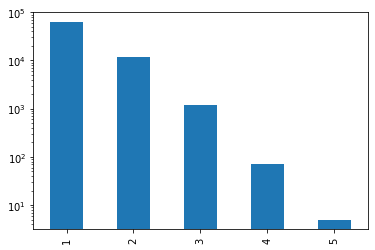

In [70]:
print(transcriptExpandedWithCounts[transcriptExpandedWithCounts.event == 'offer received'].occurrence.count())
transcriptExpandedWithCounts[transcriptExpandedWithCounts.event == 'offer received'].occurrence.value_counts().plot.bar(logy=True)

Transcripts contain event logs (306648 events x 4 fields)

- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
  - offer id: (string/hash) not associated with any "transaction"
  - amount: (numeric) money spent in "transaction"
  - reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

Although all events are filled properly, about 11% may need to be treated differently as they are related to the unfilled profiles.

Starbucks has warned not to include completed but not viewed offers; the customer may have received its reward but wasn't influenced by it because they didn't know about the offer contents.

Required pre-processing will be:

- Identifying each offering per person as some people have received the same offer 5 times
- Merging events into complete histories per received offer:
  - Hours between offer received and offer viewed
  - Hours between offer viewed and offer completed
  - Transaction total between offer viewed and offer completed
- Remove histories where offer has not been viewed
- Merge in Person and Portfolio features, delete the id's
- Split up histories for offers that were shown on multiple channels, so each record contains one offer, one channel and its total money spent
- One-hot encode channels
- Min-Max normalize the transaction total and time features

## Preprocessing

During data exploration, some preprocessing has already been done. However, to make the preprocessing repeatable for new data all steps will be replicated in methods here.

### Portfolio

- Encoding of Channels and OfferType
- Min-Max normalization of Reward, Difficulty and Duration to 0..1 values

In [71]:
def EncodeChannels(df: pd.DataFrame, column: str):
    result = pd.DataFrame(df)
    mlb = MultiLabelBinarizer()
    return result.join(pd.DataFrame(mlb.fit_transform(result.pop(column)), index=result.index, columns=mlb.classes_).add_prefix(column + '_'))

In [72]:
portfolioChannelEncoded = EncodeChannels(portfolio, 'channels')
portfolioChannelEncoded.head()

,reward,difficulty,duration,offer_type,id,channels_email,channels_mobile,channels_social,channels_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [73]:
def Encoding(df: pd.DataFrame, columns: list):
    result = pd.DataFrame(df)
    ohe = OneHotEncoder(handle_unknown='ignore')
    encoded = pd.DataFrame(ohe.fit_transform(result[columns]).toarray(), index=result.index, columns=ohe.get_feature_names_out(columns))
    return result.drop(columns=columns).join(encoded)

In [74]:
portfolioEncoded = Encoding(portfolioChannelEncoded, ['offer_type'])
portfolioEncoded.head()


,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


In [75]:
def Scaling(df: pd.DataFrame, columns: list) -> Tuple[pd.DataFrame, MinMaxScaler]:
    result = pd.DataFrame(df)
    scaler = MinMaxScaler()
    result[columns] = pd.DataFrame(scaler.fit_transform(result[columns]), index=result.index, columns=columns)
    return (result, scaler)

In [76]:
portfolioScaledEncoded, scaler = Scaling(portfolioEncoded, ['reward', 'difficulty']) # don't scale duration, we need the raw value for the transaction history compilation
portfolioScaledEncoded.head()

,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,1.0,0.50,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,1.0,0.50,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0.0,0.00,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,0.5,0.25,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,0.5,1.00,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


In [77]:
def PreprocessPortfolio(portfolio):
    portfolioChannelEncoded = EncodeChannels(portfolio, 'channels')
    portfolioEncoded = Encoding(portfolioChannelEncoded, ['offer_type'])
    # portfolioScaledEncoded = Scaling(portfolioEncoded, ['reward', 'difficulty']) # don't scale duration, we need the raw value for the transaction history compilation
    return portfolioEncoded # portfolioScaledEncoded # in fact, don't scale at all until final preprocessing step so we can get the fitted scaler

In [78]:
portfolioEncoded = PreprocessPortfolio(portfolio)
portfolioEncoded.head()

,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


### Profile

- One-hot encoding of Gender
- Translating BecameMemberOn to AccountAge in days
- Filling missing Age and Income fields with mean values for that column
- Min-Max normalization of Age, Income and AccountAge to 0..1 values

In [79]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [80]:
def PreprocessProfile(df: pd.DataFrame, ignoreNotFilled: bool = False):
    profile = pd.DataFrame(df)
    if not ignoreNotFilled:
        profile.gender = profile.gender.fillna('U')
        profileEncoded = Encoding(profile, ['gender'])
        profileEncoded.income = profileEncoded.income.fillna(profileEncoded.income.mean())
        ageNand = profileEncoded.age.replace(118, np.nan)
        profileEncoded.age = ageNand.fillna(ageNand.mean())
    else:
        profile = profile.dropna(subset=['gender', 'income'], axis=0)        
        profileEncoded = Encoding(profile, ['gender'])
        profileEncoded['gender_U'] = 0.0
    profileEncoded.became_member_on = pd.to_datetime(profileEncoded.became_member_on, format='%Y%m%d', exact=True)
    profileEncoded['account_age'] = (np.datetime64('today') - profileEncoded.became_member_on).dt.days
    return profileEncoded.drop(columns='became_member_on')

In [81]:
profileScaledEncoded = PreprocessProfile(profile)
profileScaledEncoded.head()

,age,id,income,gender_F,gender_M,gender_O,gender_U,account_age
0,54.393524,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0.0,0.0,0.0,1.0,1830
1,55.000000,0610b486422d4921ae7d2bf64640c50b,112000.000000,1.0,0.0,0.0,0.0,1677
2,54.393524,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0.0,0.0,0.0,1.0,1315
3,75.000000,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1.0,0.0,0.0,0.0,1744
4,54.393524,a03223e636434f42ac4c3df47e8bac43,65404.991568,0.0,0.0,0.0,1.0,1657


In [82]:
profileScaledEncodedWithoutUnfilled = PreprocessProfile(profile, True)
profileScaledEncodedWithoutUnfilled.head()

,age,id,income,gender_F,gender_M,gender_O,gender_U,account_age
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1.0,0.0,0.0,0.0,1677
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1.0,0.0,0.0,0.0,1744
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0.0,1.0,0.0,0.0,1392
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0.0,1.0,0.0,0.0,1468
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0.0,1.0,0.0,0.0,1558


### Transcript

- Expand JSON column)
- Merging events into complete histories per received offer with transaction totals between offer viewed and offer completed (or before the time limit has exceeded for informationals)
- Merge in Person and Portfolio features, delete the id's
- Split up histories for offers that were shown on multiple channels, so each record contains one offer, one channel and its total money spent
- Min-Max normalize the transaction total and time features

In [83]:
def ExpandTranscriptValues(df: pd.DataFrame) -> pd.DataFrame:
    transcript = pd.DataFrame(df)
    df1 = pd.DataFrame(transcript['value'].values.tolist())
    df1.columns = df1.columns
    df1.offer_id.fillna(df1['offer id'], inplace=True) # Some events call it offer_id, some offer id. So, merge those together
    del df1['offer id']

    transcriptExpanded = pd.concat([transcript, df1], axis=1)
    del transcriptExpanded['value']

    transcriptExpanded.amount = pd.to_numeric(transcriptExpanded.amount, downcast='float')
    transcriptExpanded.time = pd.to_numeric(transcriptExpanded.time, downcast='integer')
    return transcriptExpanded.astype({'offer_id':str, 'person': str, 'event': str})

In [84]:
transcriptExpanded = ExpandTranscriptValues(transcript)
transcriptExpanded.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [85]:
def MergeOfferInformation(transcript: pd.DataFrame, portfolio: pd.DataFrame) -> pd.DataFrame:
    pf = pd.DataFrame(portfolio)
    pf.duration = pf.duration * 24
    result = pd.merge(transcript, pf, left_on='offer_id', right_on='id', how='left')
    del result['id']
    return result

In [86]:
MergeOfferInformation(transcriptExpanded, Encoding(portfolioChannelEncoded, ['offer_type']))

,person,event,time,amount,offer_id,reward_x,reward_y,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
def FindViewsForReceivedOffers(transcriptExpanded: pd.DataFrame, portfolioEncoded: pd.DataFrame) -> pd.DataFrame:
    views = pd.merge(transcriptExpanded.loc[transcriptExpanded['event'] == 'offer received', ['person', 'offer_id', 'time']],
                    transcriptExpanded.loc[transcriptExpanded['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                    on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

    viewsWithOfferInfo = MergeOfferInformation(views, portfolioEncoded)
    viewsWithOfferInfo.drop_duplicates(inplace=True)

    return viewsWithOfferInfo[((viewsWithOfferInfo.time_viewed >= viewsWithOfferInfo.time_received) & (viewsWithOfferInfo.time_viewed <= viewsWithOfferInfo.time_received + viewsWithOfferInfo.duration))]

In [88]:
views = FindViewsForReceivedOffers(transcriptExpanded, portfolioScaledEncoded)
views.head()

,person,offer_id,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6.0,0.5,0.25,168,1,1,0,1,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6.0,0.5,1.00,240,1,0,0,1,0.0,1.0,0.0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18.0,0.2,0.50,168,1,1,0,1,0.0,1.0,0.0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,0.2,0.50,240,1,1,1,1,0.0,1.0,0.0
6,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,84.0,1.0,0.50,120,1,1,1,1,1.0,0.0,0.0


In [89]:
def FindCompletionsForViewedOffers(viewsWithOfferInfo: pd.DataFrame) -> pd.DataFrame:
    completions = pd.merge(viewsWithOfferInfo,
                           transcriptExpanded.loc[transcriptExpanded.event == 'offer completed', ['person', 'offer_id', 'time']],
                           on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

    completions.time_completed = completions.apply(lambda row: row.time_received + row.duration if row.offer_type_informational == 1 else row.time_completed, axis=1)
    completions = completions[(completions.time_completed.notnull()) & (completions.time_viewed <= completions.time_completed) & (completions.time_completed <= completions.time_received + completions.duration)]
    completions.drop_duplicates(inplace=True)

    return completions

In [90]:
completions = FindCompletionsForViewedOffers(views)
completions.sort_values(['person', 'offer_id', 'time_received']).head()

,person,offer_id,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,time_completed
25490,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,0.0,0.00,96,1,1,0,1,0.0,0.0,1.0,432.0
13911,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,0.0,0.00,72,1,1,1,0,0.0,0.0,1.0,240.0
37496,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,0.5,1.00,240,1,0,0,1,0.0,1.0,0.0,576.0
14203,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,0.3,0.35,168,1,1,1,1,0.0,1.0,0.0,252.0
2791,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,0.0,0.00,96,1,1,0,1,0.0,0.0,1.0,96.0


In [91]:
def CompileCustomerJourneys(completions: pd.DataFrame, transcriptExpanded: pd.DataFrame) -> pd.DataFrame:
    transactions = pd.DataFrame(transcriptExpanded.loc[transcriptExpanded.event == 'transaction', ['person', 'time', 'amount']])

    sql = '''
    select transactions.person, transactions.amount, completions.offer_id
    from transactions
    inner join completions
    on ((transactions.person = completions.person)
    and (transactions.time between completions.time_viewed and completions.time_completed))
    order by transactions.person, completions.offer_id
    '''

    transactions = psql.sqldf(sql, locals())

    totals = transactions.groupby(['person', 'offer_id']).agg({'amount': 'sum'}).reset_index()

    result = pd.merge(completions,
                    totals,
                    on=['person', 'offer_id'], how='left').fillna(0) # there are some informationals that are completed, but did not trigger any sales
    del result['offer_id']
    return result

In [92]:
journeys = CompileCustomerJourneys(completions, transcriptExpanded)
display(journeys.head())
journeys.describe()

,person,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,time_completed,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,0.5,0.25,168,1,1,0,1,1.0,0.0,0.0,132.0,19.889999
1,389bc3fa690240e798340f5a15918d5c,0,0.0,0.5,0.25,120,1,1,1,1,1.0,0.0,0.0,60.0,20.800000
2,c27e0d6ab72c455a8bb66d980963de60,0,18.0,0.0,0.00,96,1,1,0,1,0.0,0.0,1.0,96.0,68.459999
3,d53717f5400c4e84affdaeda9dd926b3,0,30.0,0.5,1.00,240,1,0,0,1,0.0,1.0,0.0,30.0,339.690002
4,f806632c011441378d4646567f357a21,0,18.0,0.2,0.50,240,1,1,1,1,0.0,1.0,0.0,126.0,46.510000


,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,time_completed,amount
count,35248.000000,35248.000000,35248.000000,35248.000000,35248.000000,35248.0,35248.000000,35248.000000,35248.000000,35248.000000,35248.000000,35248.000000,35248.000000,35248.000000
mean,331.419655,353.347197,0.346465,0.316733,148.207898,1.0,0.958409,0.720466,0.746737,0.326912,0.388419,0.284669,403.963516,31.474175
std,193.376510,194.270345,0.334699,0.247851,56.659439,0.0,0.199656,0.448776,0.434886,0.469092,0.487398,0.451263,195.273796,64.092068
min,0.000000,0.000000,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,168.000000,180.000000,0.000000,0.000000,96.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,10.550000
50%,336.000000,408.000000,0.300000,0.350000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,438.000000,19.010000
75%,504.000000,516.000000,0.500000,0.500000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,576.000000,31.802500
max,576.000000,708.000000,1.000000,1.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,714.000000,2134.460052


Now we have successfully completed offers, but from the describe, there is at least one huge outlier of $1741,57, so we'll eliminate that with Z-scoring.

In [93]:
journeys = journeys[(np.abs(stats.zscore(journeys.amount)) < 3)]
journeys.describe()

,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,time_completed,amount
count,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.0,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000
mean,331.253428,353.042286,0.346176,0.315213,147.758563,1.0,0.958804,0.719691,0.745223,0.327787,0.385277,0.286936,403.604567,26.454131
std,193.578013,194.476875,0.335074,0.247765,56.528228,0.0,0.198745,0.449156,0.435742,0.469413,0.486668,0.452338,195.467112,29.294854
min,0.000000,0.000000,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,168.000000,180.000000,0.000000,0.000000,96.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,10.480000
50%,336.000000,408.000000,0.300000,0.350000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,438.000000,18.790001
75%,504.000000,516.000000,0.500000,0.500000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,576.000000,31.120000
max,576.000000,708.000000,1.000000,1.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,714.000000,222.280005


In [94]:
def MergePersonInformation(journeys: pd.DataFrame, profile: pd.DataFrame) -> pd.DataFrame:
    result = pd.merge(journeys, profile, left_on='person', right_on='id')
    del result['person']
    del result['id']
    return result

In [95]:
history = MergePersonInformation(journeys, profileScaledEncoded)
display(history.head())
display(history.describe())

,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,0,6.0,0.5,0.25,168,1,1,0,1,1.0,...,0.0,132.0,19.889999,75.0,100000.0,1.0,0.0,0.0,0.0,1744
1,168,216.0,0.0,0.00,72,1,1,1,0,0.0,...,1.0,240.0,49.389999,75.0,100000.0,1.0,0.0,0.0,0.0,1744
2,408,408.0,1.0,0.50,168,1,1,1,0,1.0,...,0.0,510.0,21.719999,75.0,100000.0,1.0,0.0,0.0,0.0,1744
3,0,0.0,0.5,0.25,120,1,1,1,1,1.0,...,0.0,60.0,20.800000,65.0,53000.0,0.0,1.0,0.0,0.0,1468
4,336,354.0,0.2,0.50,168,1,1,0,1,0.0,...,0.0,498.0,15.630000,65.0,53000.0,0.0,1.0,0.0,0.0,1468


,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.0,34858.000000,34858.000000,34858.000000,34858.000000,...,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000
mean,331.253428,353.042286,0.346176,0.315213,147.758563,1.0,0.958804,0.719691,0.745223,0.327787,...,0.286936,403.604567,26.454131,55.252338,67526.095149,0.418096,0.496443,0.016352,0.069109,1879.709450
std,193.578013,194.476875,0.335074,0.247765,56.528228,0.0,0.198745,0.449156,0.435742,0.469413,...,0.452338,195.467112,29.294854,16.208591,20191.763459,0.493253,0.499995,0.126827,0.253643,404.764104
min,0.000000,0.000000,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,1301.000000
25%,168.000000,180.000000,0.000000,0.000000,96.000000,1.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,240.000000,10.480000,45.000000,53000.000000,0.000000,0.000000,0.000000,0.000000,1556.000000
50%,336.000000,408.000000,0.300000,0.350000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,...,0.000000,438.000000,18.790001,54.393524,65404.991568,0.000000,0.000000,0.000000,0.000000,1796.000000
75%,504.000000,516.000000,0.500000,0.500000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,576.000000,31.120000,66.000000,81000.000000,1.000000,1.000000,0.000000,0.000000,2154.000000
max,576.000000,708.000000,1.000000,1.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,714.000000,222.280005,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,3124.000000


In [96]:
def PreprocessTranscript(transcript: pd.DataFrame, portfolioScaledEncoded: pd.DataFrame, profileScaledEncoded: pd.DataFrame) -> pd.DataFrame:
    transcriptExpanded = ExpandTranscriptValues(transcript)
    views = FindViewsForReceivedOffers(transcriptExpanded, portfolioScaledEncoded)
    completions = FindCompletionsForViewedOffers(views)
    journeys = CompileCustomerJourneys(completions, transcriptExpanded)
    journeys = journeys[(np.abs(stats.zscore(journeys.amount)) < 3)]
    return MergePersonInformation(journeys, profileScaledEncoded)

In [97]:
history = PreprocessTranscript(transcript, portfolioScaledEncoded, profileScaledEncoded)
display(history.head())
display(history.describe())

,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,0,6.0,0.5,0.25,4032,1,1,0,1,1.0,...,0.0,132.0,19.889999,75.0,100000.0,1.0,0.0,0.0,0.0,1744
1,168,216.0,0.0,0.00,1728,1,1,1,0,0.0,...,1.0,1896.0,121.599998,75.0,100000.0,1.0,0.0,0.0,0.0,1744
2,408,408.0,1.0,0.50,4032,1,1,1,0,1.0,...,0.0,510.0,21.719999,75.0,100000.0,1.0,0.0,0.0,0.0,1744
3,0,0.0,0.5,0.25,2880,1,1,1,1,1.0,...,0.0,60.0,68.490001,65.0,53000.0,0.0,1.0,0.0,0.0,1468
4,0,0.0,0.5,0.25,2880,1,1,1,1,1.0,...,0.0,600.0,68.490001,65.0,53000.0,0.0,1.0,0.0,0.0,1468


,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.0,45563.000000,45563.000000,45563.000000,45563.000000,...,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000,45563.000000
mean,293.303777,353.420714,0.353690,0.316878,3540.750872,1.0,0.959924,0.720672,0.748261,0.339332,...,0.278779,938.604350,92.861837,55.375703,67717.972997,0.422580,0.493119,0.015693,0.068608,1878.161754
std,199.345650,195.856345,0.336884,0.245189,1337.394924,0.0,0.196141,0.448674,0.434017,0.473488,...,0.448403,853.458192,127.097316,16.204899,20276.281138,0.493975,0.499958,0.124285,0.252790,404.851185
min,0.000000,0.000000,0.000000,0.000000,1728.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,1301.000000
25%,168.000000,180.000000,0.000000,0.000000,2304.000000,1.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,390.000000,16.559999,46.000000,54000.000000,0.000000,0.000000,0.000000,0.000000,1555.000000
50%,336.000000,408.000000,0.300000,0.350000,4032.000000,1.0,1.000000,1.000000,1.000000,0.000000,...,0.000000,558.000000,36.149999,54.393524,65404.991568,0.000000,0.000000,0.000000,0.000000,1791.000000
75%,504.000000,516.000000,0.500000,0.500000,4032.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1728.000000,121.354999,66.000000,81000.000000,1.000000,1.000000,0.000000,0.000000,2153.000000
max,576.000000,714.000000,1.000000,1.000000,5760.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,2880.000000,818.180004,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,3124.000000


In [98]:
SCALED_COLS = ['amount', 'time_received', 'time_viewed', 'time_completed', 'duration', 'reward', 'difficulty', 'age', 'income', 'account_age']

In [99]:
def PreprocessStarbucksData(transcript: pd.DataFrame, portfolio: pd.DataFrame, profile: pd.DataFrame) -> Tuple[pd.DataFrame, MinMaxScaler]:
    history = PreprocessTranscript(transcript, PreprocessPortfolio(portfolio), PreprocessProfile(profile))
    return Scaling(history, SCALED_COLS)

In [100]:
history, scaler = PreprocessStarbucksData(transcript, portfolio, profile)
display(history.head())
display(history.describe())

,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,0.000000,0.008475,0.5,0.25,0.571429,1,1,0,1,1.0,...,0.0,0.184874,0.089482,0.686747,0.777778,1.0,0.0,0.0,0.0,0.243006
1,0.291667,0.305085,0.0,0.00,0.000000,1,1,1,0,0.0,...,1.0,0.336134,0.222197,0.686747,0.777778,1.0,0.0,0.0,0.0,0.243006
2,0.708333,0.576271,1.0,0.50,0.571429,1,1,1,0,1.0,...,0.0,0.714286,0.097715,0.686747,0.777778,1.0,0.0,0.0,0.0,0.243006
3,0.000000,0.000000,0.5,0.25,0.285714,1,1,1,1,1.0,...,0.0,0.084034,0.093576,0.566265,0.255556,0.0,1.0,0.0,0.0,0.091607
4,0.583333,0.500000,0.2,0.50,0.571429,1,1,0,1,0.0,...,0.0,0.697479,0.070317,0.566265,0.255556,0.0,1.0,0.0,0.0,0.091607


,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.0,34858.000000,34858.000000,34858.000000,34858.000000,...,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000,34858.000000
mean,0.575093,0.498647,0.346176,0.315213,0.450944,1.0,0.958804,0.719691,0.745223,0.327787,...,0.286936,0.565273,0.119013,0.448823,0.416957,0.418096,0.496443,0.016352,0.069109,0.317449
std,0.336073,0.274685,0.335074,0.247765,0.336478,0.0,0.198745,0.449156,0.435742,0.469413,...,0.452338,0.273763,0.131793,0.195284,0.224353,0.493253,0.499995,0.126827,0.253643,0.222032
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.291667,0.254237,0.000000,0.000000,0.142857,1.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.336134,0.047148,0.325301,0.255556,0.000000,0.000000,0.000000,0.000000,0.139879
50%,0.583333,0.576271,0.300000,0.350000,0.571429,1.0,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.613445,0.084533,0.438476,0.393389,0.000000,0.000000,0.000000,0.000000,0.271530
75%,0.875000,0.728814,0.500000,0.500000,0.571429,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.806723,0.140004,0.578313,0.566667,1.000000,1.000000,0.000000,0.000000,0.467910
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Benchmark

Before starting model training, a simple benchmark algorithm should be established.

For the model to be successful, it should at least recommend offers that would increase amount spent over normal spending (that is, without viewed offers or offers viewed after completion or duration runs out).

For our baseline data, we'll get all 'invalid' transactions; those that were in the timeframe of offers that were:
- not viewed,
- viewed after offer duration runs out (in case of informationals) or
- viewed after completion of the offer.

These are then totalled for each offer and these total not-influenced spendings are then averaged per person to get that person's average spending when they are not influenced by offers.

These profiles will be trained upon with the same hyperparameters as our goal model and predicted spending will be compared.

In [101]:
def GetBaselineData(transcript: pd.DataFrame, portfolio: pd.DataFrame, profile: pd.DataFrame, scaler: MinMaxScaler) -> pd.DataFrame:
    transcriptExpanded = ExpandTranscriptValues(transcript)
    views = pd.merge(transcriptExpanded.loc[transcriptExpanded['event'] == 'offer received', ['person', 'offer_id', 'time']],
                    transcriptExpanded.loc[transcriptExpanded['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                    on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])
    viewsWithOfferInfo = MergeOfferInformation(views, PreprocessPortfolio(portfolio))
    viewsWithOfferInfo.drop_duplicates(inplace=True)
    completions = pd.merge(viewsWithOfferInfo,
                           transcriptExpanded.loc[transcriptExpanded.event == 'offer completed', ['person', 'offer_id', 'time']],
                           on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

    completions.time_completed = completions.apply(lambda row: row.time_received + row.duration if row.offer_type_informational == 1 else row.time_completed, axis=1)
    
    lateViews = completions[(completions.time_viewed.isna()) | ((completions.time_viewed >= completions.time_received) & (completions.time_viewed > completions.time_completed))]
    
    transactions = pd.DataFrame(transcriptExpanded.loc[transcriptExpanded.event == 'transaction', ['person', 'time', 'amount']])

    sql = '''
    select transactions.person, transactions.amount, lateViews.offer_id
    from transactions
    inner join lateViews
    on ((transactions.person = lateViews.person)
    and (transactions.time between lateViews.time_received and lateViews.time_completed))
    order by transactions.person, lateViews.offer_id
    '''

    transactions = psql.sqldf(sql, locals())

    totals = transactions.groupby(['person', 'offer_id']).agg({'amount': 'sum'}).reset_index()

    journeys = pd.merge(lateViews,
                    totals,
                    on=['person', 'offer_id'], how='left').fillna(0) # there are some informationals that are completed, but did not trigger any sales
    del journeys['offer_id']
    journeys = journeys[(np.abs(stats.zscore(journeys.amount)) < 3)]
    journeys = journeys.groupby(by=['person']).mean().reset_index()
    history = MergePersonInformation(journeys, PreprocessProfile(profile))
    history[SCALED_COLS] = scaler.transform(history[SCALED_COLS])
    return history


In [102]:
baselineData = GetBaselineData(transcript, portfolio, profile, scaler)

In [103]:
display(baselineData)
display(baselineData.describe())

,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,0.861111,0.468927,0.300,0.416667,0.619048,1.0,1.000000,0.666667,1.00,0.333333,...,0.00,0.708683,0.049412,0.180723,0.466667,0.0,1.0,0.0,0.0,0.252880
1,0.583333,0.466102,0.500,0.250000,0.285714,1.0,1.000000,1.000000,0.00,0.500000,...,0.50,0.403361,0.114945,0.493976,0.666667,1.0,0.0,0.0,0.0,0.479430
2,0.625000,0.395480,0.300,0.666667,1.000000,1.0,0.666667,0.666667,1.00,0.000000,...,0.00,0.683473,0.062939,0.096386,0.477778,1.0,0.0,0.0,0.0,0.219419
3,0.763889,0.000000,0.300,0.666667,0.714286,1.0,0.666667,0.000000,1.00,0.000000,...,0.00,0.000000,0.000000,0.012048,0.388889,1.0,0.0,0.0,0.0,0.392759
4,0.291667,0.000000,0.000,0.000000,0.142857,1.0,1.000000,0.000000,1.00,0.000000,...,1.00,0.369748,0.000000,0.445783,0.488889,1.0,0.0,0.0,0.0,0.043335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13430,0.645833,0.264831,0.225,0.312500,0.428571,1.0,1.000000,0.250000,0.75,0.250000,...,0.25,0.571429,0.065705,0.614458,0.588889,1.0,0.0,0.0,0.0,0.570488
13431,0.625000,0.491525,0.300,0.416667,0.857143,1.0,1.000000,0.666667,1.00,0.333333,...,0.00,0.456583,0.046623,0.638554,0.477778,0.0,1.0,0.0,0.0,0.147010
13432,0.875000,0.000000,0.000,0.000000,0.142857,1.0,1.000000,0.000000,1.00,0.000000,...,1.00,0.840336,0.004004,0.638554,0.288889,0.0,1.0,0.0,0.0,0.086670
13433,0.569444,0.793785,0.500,0.250000,0.380952,1.0,1.000000,0.666667,1.00,1.000000,...,0.00,0.308123,0.037370,0.192771,0.044444,0.0,1.0,0.0,0.0,0.301152


,time_received,time_viewed,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,...,offer_type_informational,time_completed,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.0,13435.000000,13435.000000,13435.000000,13435.000000,...,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000
mean,0.570834,0.284888,0.366482,0.414479,0.532996,1.0,0.815089,0.376624,0.842032,0.317953,...,0.235423,0.377559,0.104434,0.436889,0.392481,0.376852,0.518422,0.011165,0.093562,0.289714
std,0.242646,0.309040,0.250913,0.271801,0.268655,0.0,0.314675,0.413566,0.310032,0.386065,...,0.348862,0.269211,0.195749,0.201529,0.233081,0.484615,0.499679,0.105076,0.291229,0.226885
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.437500,0.000000,0.200000,0.250000,0.357143,1.0,0.666667,0.000000,0.833333,0.000000,...,0.000000,0.134454,0.000000,0.313253,0.222222,0.000000,0.000000,0.000000,0.000000,0.117937
50%,0.583333,0.183616,0.350000,0.416667,0.571429,1.0,1.000000,0.250000,1.000000,0.000000,...,0.000000,0.380952,0.053784,0.438476,0.393389,0.000000,1.000000,0.000000,0.000000,0.205156
75%,0.729167,0.564266,0.500000,0.500000,0.678571,1.0,1.000000,0.750000,1.000000,0.500000,...,0.500000,0.588235,0.109103,0.566265,0.522222,1.000000,1.000000,0.000000,0.000000,0.440208
max,1.000000,1.008475,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.315053,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
baselineData.to_csv('./data/baselineData.csv', index=False)
history.to_csv('./data/history.csv', index=False)

joblib.dump(scaler, './model/scaler.gz')
joblib.dump(SCALED_COLS, './model/SCALED_COLS')

['./model/SCALED_COLS']